In [1]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw

In [2]:
DATA_PATH = os.getenv('HOME') + '/aiffel/object_detection/data'

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

### 다운로드한 KITTI 데이터셋을 tfds.show_examples를 통해 확인

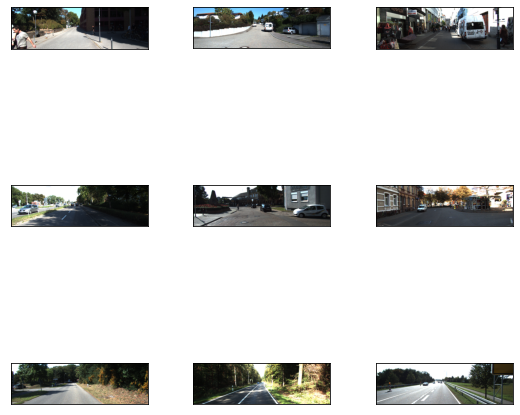

In [4]:
_ = tfds.show_examples(ds_train, ds_info)

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(9,), dtype=float32, numpy=
array([-1.59, -0.83, -2.65,  2.86,  2.39,  0.51,  2.12,  1.85, -2.89],
      dtype=float32)>, 'bbox': <tf.Tensor: shape=(9, 4), dtype=float32, numpy=
array([[0.46205333, 0.48361513, 0.53389335, 0.50570047],
       [0.00266667, 0.        , 0.50005335, 0.27213365],
       [0.17842667, 0.63347024, 0.6319733 , 0.7642834 ],
       [0.2436    , 0.63400966, 0.57384   , 0.66219   ],
       [0.28829333, 0.59455717, 0.54477334, 0.62005633],
       [0.19584   , 0.13470209, 0.53136   , 0.16664252],
       [0.27701333, 0.06727859, 0.46786666, 0.20493558],
       [0.43184   , 0.328124  , 0.5038933 , 0.36657006],
       [0.2788    , 0.61063606, 0.6062933 , 0.7017472 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(9, 3), dtype=float32, numpy=
array([[1.65, 1.67, 3.64],
       [1.61, 1.51, 4.5 ],
       [1.72, 0.47, 1.65],
       [1.6 , 0.39, 0.4 ],
       [1.5 ,

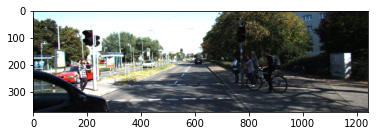

In [5]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

### 시각화

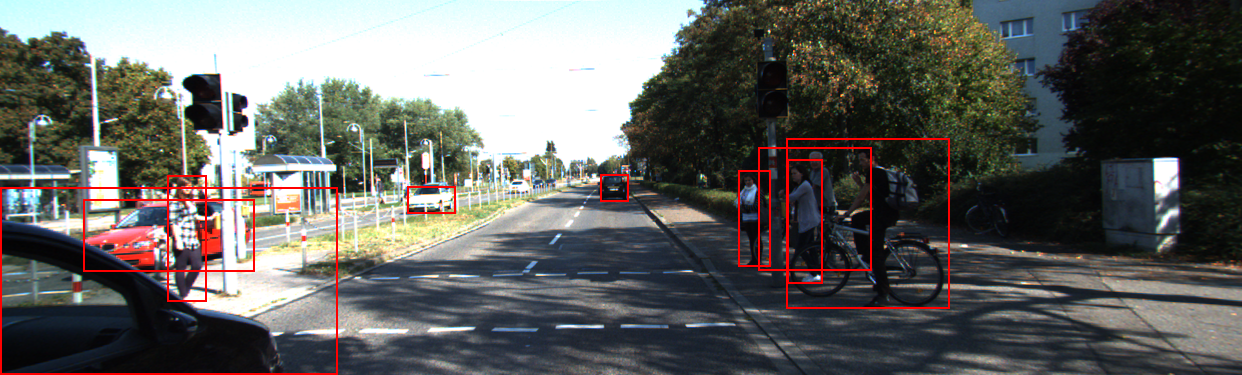

In [6]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

visualize_bbox(img, objects['bbox'].numpy())

## 4단계로 이루어진 데이터 파이프라인을 구축
1. x와 y좌표 위치 교체
2. 무작위로 수평 뒤집기(Flip)
3. 이미지 크기 조정 및 패딩 추가
4. 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정

In [7]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

In [8]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

### 이미지 비율은 유지하며 크기 제한을 주고 학습 완료 모델을 사용시엔 분기처리

In [9]:
def resize_and_pad_image(image, training=True):
    # 이미지의 최소 및 최대 크기를 정의
    min_side = 800.0
    max_side = 1333.0
    # 훈련 중에 사용할 최소 크기 범위를 정의
    min_side_range = [640, 1024]
    # 이미지를 패딩할 때 사용할 스트라이드 값을 정의
    stride = 128.0
    
    # 이미지의 형상을 가져와서 float32 타입으로 변환
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    # 훈련 중일 경우, 무작위로 최소 크기를 선택하여 데이터의 다양성 증가
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    # 이미지의 최소 변을 기준으로 리사이즈할 비율을 계산
    ratio = min_side / tf.reduce_min(image_shape)
    # 리사이즈 후 최대 변이 max_side를 초과하지 않도록 조정
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    # 새로운 이미지 형상을 계산
    image_shape = ratio * image_shape
    # 이미지를 새로운 형상으로 리사이즈
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    # 패딩을 위해 이미지 형상을 스트라이드의 배수로 제작
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    # 이미지에 패딩을 추가
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio


In [11]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

### 준비된 함수들을 연결

In [12]:
def preprocess_data(sample):
    image = sample["image"]
    # 바운딩 박스 좌표를 x, y 순서로 변경
    bbox = swap_xy(sample["objects"]["bbox"])
    # 클래스 ID를 정수형으로 변환
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    # 이미지를 무작위로 수평으로 뒤집기
    image, bbox = random_flip_horizontal(image, bbox)
    # 이미지를 리사이즈하고 패딩을 추가
    image, image_shape, _ = resize_and_pad_image(image)

    # 바운딩 박스의 좌표를 조정
    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],  # x_min
            bbox[:, 1] * image_shape[0],  # y_min
            bbox[:, 2] * image_shape[1],  # x_max
            bbox[:, 3] * image_shape[0],  # y_max
        ],
        axis=-1,
    )
    # 바운딩 박스의 좌표를 (x, y, width, height) 형식으로 변환
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id


### 인코딩

In [13]:
class AnchorBox:
    def __init__(self):
        # 앵커 박스의 가로세로 비율을 정의
        self.aspect_ratios = [0.5, 1.0, 2.0]
        # 앵커 박스의 스케일을 정의
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        # 앵커 박스의 개수를 계산
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        # 각 피쳐 맵에 사용될 스트라이드를 정의
        self._strides = [2 ** i for i in range(3, 8)]
        # 앵커 박스의 면적을 정의
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        # 앵커 박스의 차원을 계산
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        # 각 면적에 대해 앵커 박스의 차원을 계산
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                # 가로세로 비율에 따라 앵커 박스의 높이와 너비를 계산
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    # 스케일에 따라 차원을 조정
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        # 피쳐 맵의 각 위치에 대한 중심 좌표를 계산
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        # 중심 좌표와 차원을 결합하여 앵커 박스를 생성
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        # 이미지의 높이와 너비에 따라 모든 레벨의 앵커 박스를 계산
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        # 모든 레벨의 앵커 박스를 하나의 텐서로 결합
        return tf.concat(anchors, axis=0)


### IoU를 계산

In [14]:
def convert_to_corners(boxes):    
    # 주어진 박스 좌표를 중심점과 너비/높이에서 코너 좌표로 변환
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    # 두 박스 집합의 코너 좌표를 계산
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    # 두 박스 집합 간의 교차 영역의 좌상단과 우하단 좌표를 계산
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    # 교차 영역의 너비와 높이를 계산
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    # 각 박스의 넓이를 계산
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    # 합집합 영역의 넓이를 계산
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    # IoU (교차 영역 / 합집합 영역)를 계산하고 반환
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

## 실제 라벨을 Anchor Box에 맞춰주는 클래스
1. compute_iou 함수를 이용해서 IoU를 구하고 그 IoU를 기준으로 물체에 해당하는 Anchor Box와 배경이 되는 Anchor Box를 지정
2. Anchor Box와 실제 Bounding Box의 미세한 차이를 계산
3. 상하좌우의 차이, 가로세로 크기의 차이를 기록해 두는데 가로세로 크기는 로그를 사용해서 기록

In [15]:
class LabelEncoder:

    def __init__(self):
        # 앵커 박스를 초기화
        self._anchor_box = AnchorBox()
        # 박스의 변화량을 나타내는 변수를 설정
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        # 앵커 박스와 실제 박스(gt_boxes) 간의 IoU를 계산.
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        # 각 앵커 박스에 대해 가장 높은 IoU를 가진 실제 박스의 인덱스 찾기
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        # 양성 및 무시할 앵커를 결정하는 마스크를 생성
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        # 앵커 박스와 매칭된 실제 박스 간의 변화량을 계산
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        # 이미지 형상에 맞는 앵커 박스 call
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        # 앵커 박스와 실제 박스를 매칭
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        # 매칭된 실제 박스와 앵커 박스 간의 타겟을 계산
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        # 클래스 타겟을 설정
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        # 최종 레이블을 생성
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        # 배치 이미지의 형상 call
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        # 이미지에 대한 레이블을 생성
        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        # 이미지 전처리
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()


### RetinaNet에서는 FPN(Feature Pyramid Network)를 사용

In [16]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

### 각각의 head를 제작

 Object Detection의 라벨은 class와 box로 이루어지므로 각각을 추론하는 부분이 필요합니다. 그것을 head라고 합니다.   
 Backbone에 해당하는 네트워크와 FPN을 통해 pyramid layer가 추출되고 나면 그 feature들을 바탕으로 class를 예상하고, box도 예상합니다.   
 class를 예측하는 head와 box를 예측하는 head가 별도로 존재한다는 것이 중요합니다.

In [17]:
def build_head(output_filters, bias_init):
    # 헤드 모델을 순차적으로 구성
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    # 커널을 초기화하기 위한 설정
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    # 4개의 컨볼루션 레이어와 ReLU 활성화 함수를 추가
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    # 최종 출력을 위한 컨볼루션 레이어를 추가
    # 여기서 output_filters는 최종 출력 필터의 수를 의미
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    # 구성한 헤드 모델을 반환
    return head


### ResNet50을 바탕으로 하는 backbone제작

In [18]:
def get_backbone():
    # ResNet50 모델을 백본으로 설정
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    # 특정 레이어들의 출력을 백본의 출력으로 사용
    # 이 레이어들은 특징 추출에 사용될 중간 레이어들
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    # 입력과 출력을 지정하여 새로운 모델을 생성
    # 이 모델은 ResNet50의 중간 레이어들의 출력을 사용
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )


### Backbone + FPN + classification용 head + box용 head인 RetinaNet제작

In [19]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        # RetinaNet 모델을 초기화합니다. 기본 네트워크로는 주어진 백본을 사용
        super(RetinaNet, self).__init__(name="RetinaNet")
        # 특징 피라미드 네트워크(FPN)를 구성
        self.fpn = FeaturePyramid(backbone)
        # 분류할 클래스의 수를 설정
        self.num_classes = num_classes

        # 클래스 예측을 위한 헤드를 구성합니다. 초기 확률을 설정
        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        # 바운딩 박스 예측을 위한 헤드를 구성
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        # 이미지를 입력으로 받아 FPN을 통과시켜 여러 레벨의 특징을 추출
        features = self.fpn(image, training=training)
        # 이미지 배치의 크기를 구하기
        N = tf.shape(image)[0]
        # 클래스와 바운딩 박스 출력을 위한 리스트를 초기화
        cls_outputs = []
        box_outputs = []
        # 각 특징 레벨에 대해 클래스와 박스 헤드를 적용
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        # 모든 레벨의 출력을 하나로 변환
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        # 최종적으로 클래스와 박스 출력을 합쳐서 반환
        return tf.concat([box_outputs, cls_outputs], axis=-1)


### Loss에 대한 준비

In [20]:
class RetinaNetBoxLoss(tf.losses.Loss):
    # 바운딩 박스 손실을 계산하기 위한 클래스
    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        # delta 값은 손실 계산 시 사용
        self._delta = delta

    def call(self, y_true, y_pred):
        # 실제 값과 예측 값의 차이를 계산
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        # smooth L1 손실을 계산
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):
    # 분류 손실을 계산하기 위한 클래스
    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        # alpha와 gamma는 focal loss 계산에 사용
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        # 시그모이드 크로스 엔트로피를 계산
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        # focal loss를 계산
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):
    # RetinaNet의 전체 손실을 계산하기 위한 클래스
    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        # 분류 손실과 박스 손실을 초기화
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        # 예측 값을 float32 타입으로 변환
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        # 바운딩 박스 레이블과 예측 값을 분리
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        # 클래스 레이블과 예측 값을 분리
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        # 양성 및 무시할 샘플을 위한 마스크를 생성
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        # 분류 손실과 박스 손실을 계산
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        # 무시할 샘플에 대한 손실을 0으로 설정
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        # 손실을 정규화
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        # 최종 손실을 반환
        loss = clf_loss + box_loss
        return loss


In [21]:
class DecodePredictions(tf.keras.layers.Layer):
    # 예측 결과를 해석하고 후처리하는 레이어

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        # 클래스 수, 신뢰도 임계값, NMS IOU 임계값 등을 설정
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        # 앵커 박스와 박스 변화량을 설정
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        # 박스 예측값을 실제 박스 좌표로 변환
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        # 이미지와 예측값을 입력으로 받아 박스 좌표와 클래스 확률을 계산
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        # Non-Max Suppression을 적용하여 최종 탐지 결과를 반환
        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )


### 클래스와 함수를 이용해서 모델을 조립

In [22]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

### Learning Rate 변경

In [23]:
# 학습률을 단계별로 설정
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
# 학습률이 변경되는 경계 지점을 설정
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
# PiecewiseConstantDecay를 사용하여 학습률을 단계별로 조정
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
# SGD 옵티마이저를 사용하고, 모멘텀을 0.9로 설정
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
# 모델을 컴파일합니다. 손실 함수와 최적화 방법을 지정
model.compile(loss=loss_fn, optimizer=optimizer)


### 데이터 전처리를 위한 파이프라인 제작

In [24]:
# 레이블 인코더를 초기화
label_encoder = LabelEncoder()
# KITTI 데이터셋을 로드 후 훈련 및 검증 데이터셋으로 분할하고 정보도 call
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

# 데이터셋을 효율적으로 처리하기 위한 자동 튜닝 변수
autotune = tf.data.AUTOTUNE

# 훈련 데이터셋을 전처리
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
# 데이터를 섞기
train_dataset = train_dataset.shuffle(8 * batch_size)
# 배치 크기로 데이터를 묶고 패딩 추가
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
# 레이블 인코딩을 적용
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
# 데이터를 미리 call
train_dataset = train_dataset.prefetch(autotune)

# 검증 데이터셋에 대해서도 동일한 전처리와 패딩, 레이블 인코딩을 적용
val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)


### 15 epoch으로 학습

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints_new/'
callbacks_list = [
    ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="val_loss",  
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    ),
    EarlyStopping(
        monitor='val_loss',  
        patience=3,  
        verbose=1
    )
]

epochs = 15

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)


Epoch 1/15
3173/3173 [==============================] - 1614s 504ms/step - loss: 2.3810 - val_loss: 1.7866

Epoch 00001: saving model to /aiffel/aiffel/object_detection/data/checkpoints_new/weights_epoch_1
Epoch 2/15
3173/3173 [==============================] - 1596s 503ms/step - loss: 1.0378 - val_loss: 1.2866

Epoch 00002: saving model to /aiffel/aiffel/object_detection/data/checkpoints_new/weights_epoch_2
Epoch 3/15
3173/3173 [==============================] - 1598s 503ms/step - loss: 0.7547 - val_loss: 1.0915

Epoch 00003: saving model to /aiffel/aiffel/object_detection/data/checkpoints_new/weights_epoch_3
Epoch 4/15
3173/3173 [==============================] - 1598s 503ms/step - loss: 0.6051 - val_loss: 1.0271

Epoch 00004: saving model to /aiffel/aiffel/object_detection/data/checkpoints_new/weights_epoch_4
Epoch 5/15
3173/3173 [==============================] - 1597s 503ms/step - loss: 0.4961 - val_loss: 0.9872

Epoch 00005: saving model to /aiffel/aiffel/object_detection/data/ch

In [ ]:
# model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints/'
# latest_checkpoint = tf.train.latest_checkpoint(model_dir)
# model.load_weights(latest_checkpoint)

### 모델의 추론 결과를 처리할 함수를 레이어 형식으로 제작

In [26]:
class DecodePredictions(tf.keras.layers.Layer):
    # 예측 결과를 해석하고 후처리하는 레이어

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        # 클래스 수, 신뢰도 임계값, NMS IOU 임계값 등을 설정
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        # 앵커 박스와 박스 변화량을 설정
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        # 박스 예측값을 실제 박스 좌표로 변환
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        # 이미지와 예측값을 입력으로 받아 박스 좌표와 클래스 확률을 계산
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        # Non-Max Suppression을 적용하여 최종 탐지 결과를 반환
        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )


### 모델 조립

In [27]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

### 모델의 추론 결과를 시각화

In [28]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    # 이미지를 numpy 배열로 변환하고 시각화를 준비
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)  
    plt.axis("off") 
    plt.imshow(image)
    ax = plt.gca()  

    # 각 탐지된 객체에 대해 반복
    for box, _cls, score in zip(boxes, classes, scores):
        # 클래스와 점수를 텍스트로 표시
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        # matplotlib에서는 이미지의 좌하단이 원점이므로 좌표를 조정
        origin_x, origin_y = x1, image.shape[0] - y2
        w, h = x2 - x1, y2 - y1  # 너비와 높이를 계산
        # 탐지된 객체 주변에 사각형을 제작
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)  # 사각형을 Axes에 추가
        # 텍스트를 이미지 위에 표시
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax


### 추론시에 입력 데이터를 전처리하기 위한 함수

In [52]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

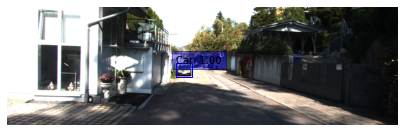

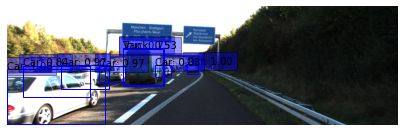

In [29]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

### 밝기조절 없는 버전

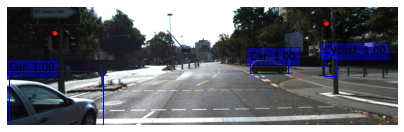

0번째 박스의 바운딩 박스 가로: 117.92 | 세로: 43.43
1번째 박스의 바운딩 박스 가로: 295.06 | 세로: 170.03
2번째 박스의 바운딩 박스 가로: 39.39 | 세로: 70.61
Go


In [62]:
import cv2
import tensorflow as tf

# 이미지 경로를 설정합니다.
img_path = os.getenv('HOME')+'/aiffel/object_detection/data/stop_3.png'

def self_drive_assist(img_path, size_limit=300):
    image_bgr = cv2.imread(img_path)
    # BGR 이미지를 RGB로 변환
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    # 이미지를 float32 타입으로 변환
    image = tf.cast(image_rgb, dtype=tf.float32)
    # 이미지를 모델에 입력하기 전에 준비
    input_image, ratio = prepare_image(image)
    # 모델을 사용하여 이미지에서 객체를 탐지
    detections = inference_model.predict(input_image)
    # 탐지된 객체의 수 call
    num_detections = detections.valid_detections[0]
    # 탐지된 객체의 클래스 이름 call
    class_names = [int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]]

    # 탐지된 객체를 이미지 위에 시각화
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

    # 탐지된 객체가 하나라도 있는 경우
    if num_detections > 0: 
        # 'Pedestrian'(보행자)가 탐지된 경우 "Stop"을 반환
        if 'Pedestrian' in class_names:
            return "Stop"

        # 각 탐지된 객체의 바운딩 박스를 확인
        box_list = detections.nmsed_boxes[0][:num_detections] / ratio
        for index, box in enumerate(box_list):
            # 바운딩 박스의 좌표 call
            x_min, y_min, x_max, y_max = box
            # 바운딩 박스의 너비와 높이를 계산
            box_width = (x_max - x_min).numpy()
            box_height = (y_max - y_min).numpy()
            # 바운딩 박스의 너비와 높이를 출력
            print(f'{index}번째 박스의 바운딩 박스 가로: {box_width:.2f} | 세로: {box_height:.2f}')

            # 너비나 높이가 size_limit보다 큰 경우 "Stop"을 반환
            if box_width > size_limit or box_height > size_limit:
                return "Stop"
    # 위 조건에 해당하지 않는 경우 "Go"를 반환
    return "Go"

print(self_drive_assist(img_path))


In [63]:
def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        print(f"\n 정답은{answer}, 하지만 예측은 {pred}")
        if pred == answer:
            score += 10
    print(f"\n{score}점입니다.")

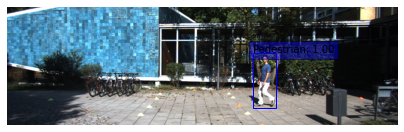


 정답은Stop, 하지만 예측은 Stop


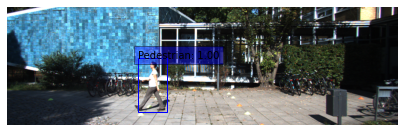


 정답은Stop, 하지만 예측은 Stop


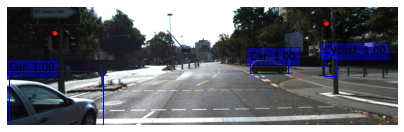

0번째 박스의 바운딩 박스 가로: 117.92 | 세로: 43.43
1번째 박스의 바운딩 박스 가로: 295.06 | 세로: 170.03
2번째 박스의 바운딩 박스 가로: 39.39 | 세로: 70.61

 정답은Stop, 하지만 예측은 Go


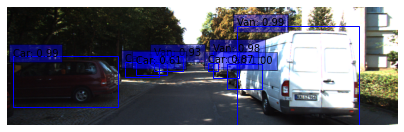

0번째 박스의 바운딩 박스 가로: 109.43 | 세로: 46.16
1번째 박스의 바운딩 박스 가로: 110.50 | 세로: 79.69
2번째 박스의 바운딩 박스 가로: 335.30 | 세로: 160.70

 정답은Stop, 하지만 예측은 Stop


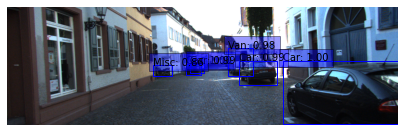

0번째 박스의 바운딩 박스 가로: 50.30 | 세로: 35.21
1번째 박스의 바운딩 박스 가로: 367.87 | 세로: 200.73

 정답은Stop, 하지만 예측은 Stop


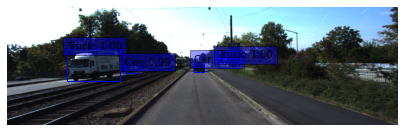

0번째 박스의 바운딩 박스 가로: 33.00 | 세로: 30.30
1번째 박스의 바운딩 박스 가로: 62.81 | 세로: 32.86
2번째 박스의 바운딩 박스 가로: 169.07 | 세로: 101.85
3번째 박스의 바운딩 박스 가로: 42.38 | 세로: 24.13

 정답은Go, 하지만 예측은 Go


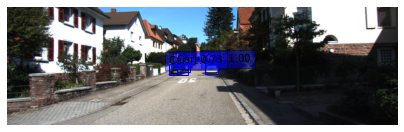

0번째 박스의 바운딩 박스 가로: 39.12 | 세로: 39.11
1번째 박스의 바운딩 박스 가로: 58.43 | 세로: 34.95
2번째 박스의 바운딩 박스 가로: 41.40 | 세로: 27.78

 정답은Go, 하지만 예측은 Go


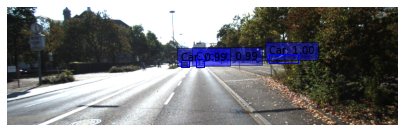

0번째 박스의 바운딩 박스 가로: 91.56 | 세로: 29.12
1번째 박스의 바운딩 박스 가로: 23.87 | 세로: 22.72
2번째 박스의 바운딩 박스 가로: 26.71 | 세로: 21.24

 정답은Go, 하지만 예측은 Go


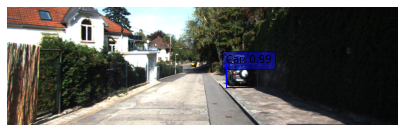

0번째 박스의 바운딩 박스 가로: 99.38 | 세로: 74.51

 정답은Go, 하지만 예측은 Go


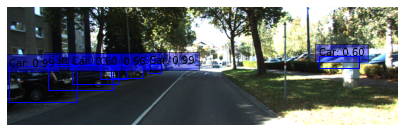

0번째 박스의 바운딩 박스 가로: 206.25 | 세로: 81.78
1번째 박스의 바운딩 박스 가로: 213.17 | 세로: 112.97
2번째 박스의 바운딩 박스 가로: 101.40 | 세로: 44.55
3번째 박스의 바운딩 박스 가로: 38.38 | 세로: 29.31
4번째 박스의 바운딩 박스 가로: 87.06 | 세로: 44.12
5번째 박스의 바운딩 박스 가로: 146.31 | 세로: 62.03
6번째 박스의 바운딩 박스 가로: 129.14 | 세로: 38.24

 정답은Go, 하지만 예측은 Go

90점입니다.


In [64]:
test_system(self_drive_assist)

### 밝기 조절을 사용한

### 이미지 밝기 조절 함수

In [65]:
def increase_brightness(img, value):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)  # 이미지를 HSV로 변환
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2RGB)  # HSV를 RGB로 변환
    return img

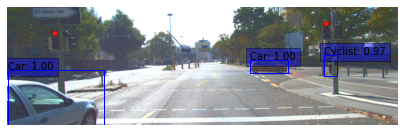

0번째 박스의 바운딩 박스 가로: 301.05 | 세로: 171.51
Stop


In [56]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/data/stop_3.png'

def self_drive_assist_bright(img_path, size_limit=300):
    image_bgr = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)  # BGR to RGB
    image_bright = increase_brightness(image_rgb, value=60)  # 밝기를 높임
    image = tf.cast(image_bright, dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]]

    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

    if num_detections > 0: 
        if 'Pedestrian' in class_names:
            return "Stop"

        box_list = detections.nmsed_boxes[0][:num_detections] / ratio
        for index, box in enumerate(box_list):
            x_min, y_min, x_max, y_max = box
            box_width = (x_max - x_min).numpy()
            box_height = (y_max - y_min).numpy()
            print(f'{index}번째 박스의 바운딩 박스 가로: {box_width:.2f} | 세로: {box_height:.2f}')

            if box_width > size_limit or box_height > size_limit:
                return "Stop"
    return "Go"

print(self_drive_assist_bright(img_path))


In [57]:
def test_system_bright(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        print(f"\n 정답은{answer}, 하지만 예측은 {pred}")
        if pred == answer:
            score += 10
    print(f"\n{score}점입니다.")

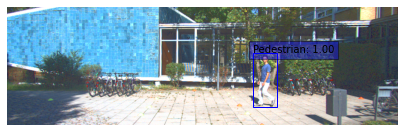


 정답은Stop, 하지만 예측은 Stop


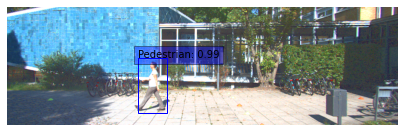


 정답은Stop, 하지만 예측은 Stop


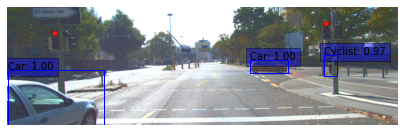

0번째 박스의 바운딩 박스 가로: 301.05 | 세로: 171.51

 정답은Stop, 하지만 예측은 Stop


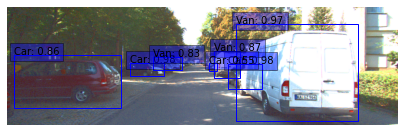

0번째 박스의 바운딩 박스 가로: 109.48 | 세로: 81.04
1번째 박스의 바운딩 박스 가로: 106.42 | 세로: 41.66
2번째 박스의 바운딩 박스 가로: 386.42 | 세로: 308.81

 정답은Stop, 하지만 예측은 Stop


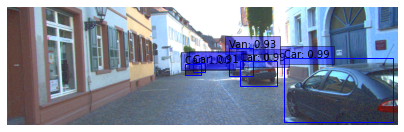

0번째 박스의 바운딩 박스 가로: 49.03 | 세로: 34.37
1번째 박스의 바운딩 박스 가로: 119.57 | 세로: 78.27
2번째 박스의 바운딩 박스 가로: 346.30 | 세로: 205.46

 정답은Stop, 하지만 예측은 Stop


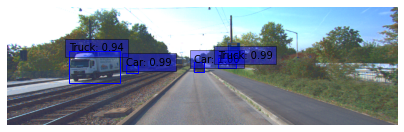

0번째 박스의 바운딩 박스 가로: 31.61 | 세로: 29.98
1번째 박스의 바운딩 박스 가로: 57.83 | 세로: 30.65
2번째 박스의 바운딩 박스 가로: 37.60 | 세로: 24.85
3번째 박스의 바운딩 박스 가로: 161.80 | 세로: 103.90

 정답은Go, 하지만 예측은 Go


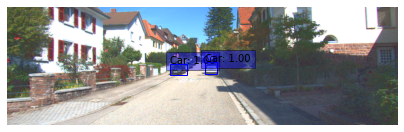

0번째 박스의 바운딩 박스 가로: 53.99 | 세로: 34.79
1번째 박스의 바운딩 박스 가로: 37.95 | 세로: 38.44

 정답은Go, 하지만 예측은 Go


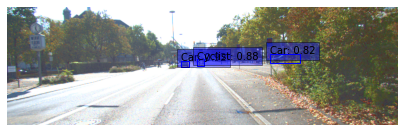

0번째 박스의 바운딩 박스 가로: 26.43 | 세로: 21.10
1번째 박스의 바운딩 박스 가로: 23.91 | 세로: 22.62
2번째 박스의 바운딩 박스 가로: 93.25 | 세로: 29.28

 정답은Go, 하지만 예측은 Go


0번째 박스의 바운딩 박스 가로: 96.17 | 세로: 72.91

 정답은Go, 하지만 예측은 Go


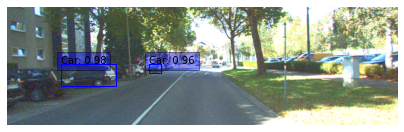

0번째 박스의 바운딩 박스 가로: 175.80 | 세로: 70.00
1번째 박스의 바운딩 박스 가로: 36.98 | 세로: 28.45

 정답은Go, 하지만 예측은 Go

100점입니다.


In [58]:
test_system_bright(self_drive_assist_bright)

### 회고


100점을 찍긴 했지만 밝기 조절로 만든 100점이라 좀 걸린다. 하지만 밝기조절을 안해도 90점은 넘기지만   
바운딩 박스가 제대로 씌워지지 않는 문제에 대한 다른 해결방안도 있을 것 같다.   
이미지 시각화를 해보면 모든 자동차에 대한 바운딩 박스가 씌워지지 않는 걸 보니 학습을 더 많이 해야 인식을 하는건지 아니면      
차의 뒷부분만 나와있으면 인식을 못하는건지 확인하고 싶지만 학습 시간이 너무 오래걸려서 확인을 못했기에 시간날때 한번 확인해보고 싶다.   
점수 달성하느라 굉장히 힘들었습니다..